In [31]:
# necessary imports
import pandas as pd
import os
import matplotlib.pyplot as plt
import plotly.graph_objects as go # https://plot.ly/python/choropleth-maps/

# for enhanced plotting
# https://amaral.northwestern.edu/blog/step-step-how-plot-map-slider-represent-time-evolu
import plotly
import plotly.offline as offline
from plotly.graph_objs import *
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# https://python-graph-gallery.com/292-choropleth-map-with-folium/
import folium

import time
import datetime


init_notebook_mode(connected=True)

In [50]:
def loadIndicatorData(dir = '', idct = ''):
    df = pd.read_csv('./ut-health-project/data/' + dir + '/' + idct + '.csv')
    if 'geoId' in df.columns:
        df = df.drop(columns = ['geoId'], axis = 1) 
    
    return df

def loadBCHIData():
    bchi_df = pd.read_csv('./ut-health-project/data/BCHI-dataset_2019-03-04.csv')
    bchi_df = bchi_df.drop(columns = ['BCHC Requested Methodology', 'Source', 'Methods', 'Notes', '90% Confidence Level - Low', '90% Confidence Level - High', '95% Confidence Level - Low', '95% Confidence Level - High'], axis = 1)

    return bchi_df

In [79]:


def plotOnUSMap(locs, values, title, maintext):
    '''
        needs a 'code' column in the dataframe (e.g. states) -> @param locs
    '''
    fig = go.Figure(data = go.Choropleth(
        locations = locs,
        z = values.astype(float),
        locationmode = 'USA-states',
        colorscale = 'Reds',
        colorbar_title = title
    ))

    fig.update_layout(
        title_text = maintext,
        geo_scope = 'usa', # limits map scope to USA
    )

    #fig.show()
    return fig

def genFoliumMap(title, state_data, cols, mapType = 'states'):
    # Load the shape of the zone (US states)
    # Find the original file here: https://github.com/python-visualization/folium/tree/master/examples/data
    # You have to download this file and set the directory where you saved it
    state_geo = os.path.join('./ut-health-project/data/', 'us-states.json')
    counties_geo = os.path.join('./ut-health-project/data/', 'us-counties.json')
    
    # Load the unemployment value of each state
    # Find the original file here: https://github.com/python-visualization/folium/tree/master/examples/data
    #state_unemployment = os.path.join('./ut-health-project/data/', 'US_Unemployment_Oct2012.csv')
    #state_data = pd.read_csv(state_unemployment)
    
    # Initialize the map:
    m = folium.Map(location=[37, -102], zoom_start=5)
    
    if(mapType == 'states'):
        # Add the color for the chloropleth:
        folium.Choropleth(
            geo_data=state_geo,
            #name='choropleth',
            data=state_data,
            columns=cols,
            key_on='feature.id',
            fill_color='YlGn',
            #fill_opacity=0.7,
            line_opacity=0.2,
            legend_name=title,
            marker_line_color='white',
            #highlight=True,
            z = state_data['value'],
            bins=[60, 65, 70, 75, 80, 85]
        ).add_to(m)
    elif(mapType == 'counties'):
        # https://www.fsanmartin.co/folium-choropleth-percentage-of-foreigners-by-us-county/
        folium.Choropleth(
            geo_data=counties_geo,
            #name='choropleth',
            data=state_data,
            columns=cols,
            key_on='properties.NAME',
            fill_color='YlGn',
            fill_opacity=0.7,
            line_opacity=0.2,
            legend_name='Test'
            #marker_line_color='white',
            #highlight=True,
            #z = state_data['value'],
            #bins=[60, 65, 70, 75, 80, 85]
        ).add_to(m)
    
    # Save to html
    #m.save(title +'_' + datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d_%H:%M:%S') + '.html')
    return m

def plotOnUSMapWithSlider(df, title, maintext):
    data_slider = []
    steps = [] # slider steps
    years = df.year.unique()

    for year in years:
        df_per_year = df[(df.year == year)]
        data_of_year = dict(
            type = 'choropleth',
            locations = df_per_year['state_abbr'],
            z = df_per_year['value'].astype(float),
            colorscale = 'Reds',
            colorbar_title = title
        )

        data_slider.append(data_of_year)

    for i in range(len(data_slider)):
        step = dict(method='restyle',
                    args=['visible', [False] * len(data_slider)],
                    label='Year {}'.format(i + 2010)) # label to be displayed for each step (year)
        step['args'][1][i] = True
        steps.append(step)

    sliders = [dict(active=0, pad={"t": 1}, steps=steps)]

    layout = dict(geo=dict(scope='usa'),
              sliders=sliders)

    # I create the figure object:
    fig = dict(data=data_slider, layout=layout) 

    return fig

In [76]:
# Life Expectancy, USA, Years: 2010, 2014
life_expectancy_total_1014 = loadIndicatorData('life-expectancy', 'life-expectancy')
life_expectancy_total_1014.head()

# Life Expectancy, USA, Years: 1900 - 2017
life_expectancy_total = loadIndicatorData('life-expectancy', 'life_expectancy_total')
#life_expectancy_total.head(25)

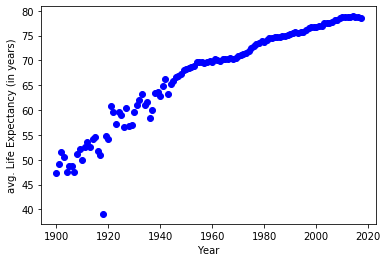

In [5]:
plot_data = life_expectancy_total[(life_expectancy_total.Race == 'All Races') & (life_expectancy_total.Sex == 'Both Sexes')] 
plt.plot(plot_data['Year'], plot_data['Average Life Expectancy (Years)'], 'bo')
plt.ylabel('avg. Life Expectancy (in years)')
plt.xlabel('Year')
plt.show()

In [6]:
plot_data.tail(10)

,Year,Race,Sex,Average Life Expectancy (Years),Age-adjusted Death Rate
108,2008,All Races,Both Sexes,78.2,774.9
109,2009,All Races,Both Sexes,78.5,749.6
110,2010,All Races,Both Sexes,78.7,747.0
111,2011,All Races,Both Sexes,78.7,741.3
112,2012,All Races,Both Sexes,78.8,732.8
113,2013,All Races,Both Sexes,78.8,731.9
114,2014,All Races,Both Sexes,78.9,724.6
115,2015,All Races,Both Sexes,78.7,733.1
116,2016,All Races,Both Sexes,78.7,728.8
117,2017,All Races,Both Sexes,78.6,731.9


Volatile in the beginning (outlier: 1918), but since the 1950 the life expectancy increases (up until 2016), then it starts to decline a bit. As a side remark: in 2016 the global life expectancy was 72 years (WHO).
Let's check now for the LE within the USA.

In [7]:
# Average LE per area, Years: 2010, 2014
life_expectancy_total_1014_grouped = life_expectancy_total_1014.groupby(['metro_nonmetro', 'year'], as_index = False).mean()
life_expectancy_total_1014_grouped = life_expectancy_total_1014_grouped.append(pd.DataFrame({"metro_nonmetro":["USA", "USA"], "year":[2010, 2014], "value":[78.7, 78.9]}), ignore_index = True) # add data for USA total

life_expct_1014_per_state = life_expectancy_total_1014.groupby(['metro_nonmetro', 'state_abbr', 'year'], as_index=False).mean()

In [8]:
life_expectancy_total_1014_grouped

,metro_nonmetro,year,value
0,Metropolitan,2010,78.121184
1,Metropolitan,2014,78.227539
2,Nonmetropolitan,2010,77.449970
3,Nonmetropolitan,2014,77.469266
4,USA,2010,78.700000
5,USA,2014,78.900000


In [17]:
# Top 15 states per life expectancy
print(life_expct_1014_per_state[life_expct_1014_per_state.year == 2014].sort_values(by=['value'], ascending=[0])[0:15])

# Worst 15 states per life expectancy
print(life_expct_1014_per_state[life_expct_1014_per_state.year == 2014].sort_values(by=['value'], ascending=[0])[-15:])

metro_nonmetro state_abbr  year      value
137  Nonmetropolitan         MA  2014  81.306667
23      Metropolitan         HI  2014  81.116667
47      Metropolitan         MN  2014  80.928519
115  Nonmetropolitan         CT  2014  80.740000
121  Nonmetropolitan         HI  2014  80.610000
11      Metropolitan         CO  2014  80.524118
13      Metropolitan         CT  2014  80.504286
79      Metropolitan         RI  2014  80.424000
145  Nonmetropolitan         MN  2014  80.402667
83      Metropolitan         SD  2014  80.313750
9       Metropolitan         CA  2014  80.284595
39      Metropolitan         MA  2014  80.216364
93      Metropolitan         VT  2014  80.210000
97      Metropolitan         WI  2014  80.206923
25      Metropolitan         IA  2014  80.112381
      metro_nonmetro state_abbr  year      value
117  Nonmetropolitan         FL  2014  75.994783
193  Nonmetropolitan         WV  2014  75.979118
5       Metropolitan         AR  2014  75.918000
37      Metropolitan      

In [43]:
life_expct_1014_per_state['state_abbr'].unique()

array(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
       'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
       'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
       'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
       'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'], dtype=object)

In [70]:
# print as map
state_data = life_expct_1014_per_state[life_expct_1014_per_state.year == 2014]
genFoliumMap(title = 'Life Expectancy per State (2014)', state_data = state_data, cols=['state_abbr', 'value'])

In [16]:
life_expct_1014_per_state.groupby(['metro_nonmetro', 'year'], as_index = False).mean()

,metro_nonmetro,year,value
0,Metropolitan,2010,78.523808
1,Metropolitan,2014,78.647840
2,Nonmetropolitan,2010,77.829050
3,Nonmetropolitan,2014,77.892211


Metropolitan areas are amongst the locations with the highest life expectancy (as of 2014), although NM areas in Massachussetts are, in total, the regions with the highest life expectancy. Hawaii follows second. More NM areas are having the lowest life expectancy, with NM in Mississippi are last. One thing which should be considered here is, that not all the states are equally sized or have the same amount of counties/inhabitants.

In [77]:
life_expectancy_total_2014_counties = life_expectancy_total_1014[life_expectancy_total_1014['year'] == 2014]
print(life_expectancy_total_2014_counties.head())

metro_nonmetro  year           county_name state_abbr  value
1166   Metropolitan  2014             Anchorage         AK  78.68
1167   Metropolitan  2014  Fairbanks North Star         AK  79.35
1168   Metropolitan  2014     Matanuska-Susitna         AK  78.11
1169   Metropolitan  2014               Autauga         AL  75.67
1170   Metropolitan  2014               Baldwin         AL  78.08


In [81]:
genFoliumMap(title='Life Expectancy per County (2014)', state_data=life_expectancy_total_2014_counties, cols = ['county_name', 'value'], mapType='counties')

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xf1 in position 13337350: invalid continuation byte

In [18]:
# TODO work out a better chart

#fig, ax = plt.subplots()
#for label, grp in life_expectancy_total_1014_grouped.groupby('metro_nonmetro'):
#    grp.plot(x = 'year', y = 'value', ax = ax, label = label, kind = 'line')

In [11]:
median_age_per_state = loadIndicatorData(dir = 'median-age', idct = 'median-age')
median_age_per_state

,metro_nonmetro,year,county_name,state_abbr,value
0,Metropolitan,2010,Anchorage Municipality,AK,32.8
1,Metropolitan,2010,Fairbanks North Star Borough,AK,30.9
2,Metropolitan,2010,Matanuska-Susitna Borough,AK,34.7
3,Metropolitan,2010,Autauga County,AL,37.1
4,Metropolitan,2010,Baldwin County,AL,41.2
...,...,...,...,...,...
25131,Nonmetropolitan,2017,Sweetwater County,WY,32.8
25132,Nonmetropolitan,2017,Teton County,WY,36.5
25133,Nonmetropolitan,2017,Uinta County,WY,33.8
25134,Nonmetropolitan,2017,Washakie County,WY,42.9


In [12]:
#plotly.offline.iplot(plotOnUSMap(median_age_per_state['state_abbr'], median_age_per_state['value'], 'Median Age', 'My First Choropleth'))

In [13]:
#plotly.offline.iplot(plotOnUSMapWithSlider(median_age_per_state, 'Median Age', 'map with slider'))

/home/lefko/anaconda3/envs/lfi/lib/python3.7/site-packages/folium/folium.py:415: FutureWarning:

The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.

